In [1]:
from __future__ import annotations

In [62]:
from pathlib import Path
import json
from dataclasses import dataclass
from PIL import Image


@dataclass
class Frame:
    image: Image
    matrix: list[list[float]]


class Scene:
    def __init__(self, path: Path):
        with open(path / "transforms.json", "r") as f:
            transforms = json.load(f)

        self.shape = (transforms["w"], transforms["h"])
        self.angles = (transforms["camera_angle_x"], transforms["camera_angle_y"])
        self.offset = (
            (
                2.0 * transforms["cx"] / transforms["w"] - 1.0,
                -2.0 * transforms["cy"] / transforms["h"] - 1.0,
            ),
        )

        self.frames: list[Frame] = []
        for frame in transforms["frames"]:
            image_path = path / frame["file_path"]
            if image_path.exists():
                self.frames.append(
                    Frame(
                        image=Image.open(image_path),
                        matrix=frame["transform_matrix"],
                    ),
                )


scene = Scene(Path("assets/fox"))

In [63]:
import torch as tch
from torch import nn
from torch.nn import functional as F
import numpy as np

In [64]:
dev = tch.device("cuda:0")

In [65]:
@dataclass
class Rays:
    pos: tch.Tensor  # shape: (B, 3)
    dir: tch.Tensor  # shape: (B, 3)

    def advance(self, step: float | tch.Tensor) -> Rays:
        return Rays(self.pos + self.dir * step, self.dir)

    @property
    def device(self) -> tch.device:
        return self.pos.device


@dataclass
class Radiance:
    color: tch.Tensor  # shape: (B, 3)
    density: tch.Tensor  # shape: (B, 1)

    @staticmethod
    def zero(bs: int, dev: tch.device) -> Radiance:
        return Radiance(tch.zeros((bs, 3), device=dev), tch.zeros((bs, 1), device=dev))

    def blend(self, add: Radiance, step: float | tch.Tensor) -> Radiance:
        new_density = self.density + add.density * step
        new_color = self.color + add.color * add.density * tch.exp(-new_density)
        return Radiance(new_color, new_density)

In [66]:
from typing import Callable


def raymarch(
    func: Callable[[Rays], Radiance],
    init_rays: Rays,
    step_size: float | tuple[float, float],
    num_steps: int,
) -> Radiance:
    bs = init_rays.pos.shape[0]
    dev = init_rays.device

    distances = tch.zeros((bs, 1), device=dev)
    total_radiance = Radiance.zero(bs, dev)
    for i in range(num_steps):
        rays = init_rays.advance(distances)

        radiance = func(rays)

        if isinstance(step_size, float):
            step = step_size
        else:
            step = step_size[0] + (step_size[1] - step_size[0]) * tch.rand(
                (bs, 1), device=dev
            )
        distances += step

        total_radiance = total_radiance.blend(radiance, step)

    return total_radiance


In [71]:
from nerfpg import grid


def pad_right(t: tch.Tensor, value: float, count: int = 1) -> tch.Tensor:
    return tch.cat(
        [t, tch.tensor(value, device=t.device).broadcast_to((*t.shape[:-1], count))],
        dim=-1,
    )


def rays_init(
    coords: tch.Tensor,
    transform: list[list[float]],
    angles: tuple[float, float],
    offset: tuple[float, float] = (0.0, 0.0),
) -> Rays:
    """
    coords shape: (B, 2) where coordinates are in a range from 0.0 to 1.0
    """
    dev = coords.device
    bs = coords.shape[0]

    matrix = tch.tensor(transform, device=dev)

    dxy = (2.0 * coords - 1.0) * tch.tensor([1.0, -1.0], device=dev).unsqueeze(0)
    dxy = dxy - tch.tensor(offset, device=dev)
    dxy = dxy * (tch.tensor(angles, device=dev) / 2.0).tan()

    dir = pad_right(dxy, -1.0)
    dir = dir / dir.pow(2).sum(dim=-1, keepdim=True)  # normalize direction vectors
    dir = tch.einsum("bi,ji->bj", dir, matrix[:3, :3])

    pos = matrix[:3, 3].reshape((1, 3)).broadcast_to((bs, 3))
    return Rays(pos, dir)


def rays_grid(
    shape: tuple[int, int],
    dev: tch.device,
    transform: list[list[float]],
    angles: tuple[float, float],
    offset: tuple[float, float] = (0.0, 0.0),
) -> Rays:
    return rays_init(grid(shape, dev).transpose(0, 1).flatten(0, 1), transform, angles, offset=offset)


res = (256, 256)
distance = 4.0
transform = [
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, distance],
    [0.0, 0.0, 0.0, 1.0],
]
rays = rays_grid(res, dev, transform, (np.pi / 2, np.pi / 2), offset=(0.1, 0.1))
rays

Rays(pos=tensor([[0., 0., 4.],
        [0., 0., 4.],
        [0., 0., 4.],
        ...,
        [0., 0., 4.],
        [0., 0., 4.],
        [0., 0., 4.]], device='cuda:0'), dir=tensor([[-0.3642,  0.2980, -0.3311],
        [-0.3637,  0.2997, -0.3330],
        [-0.3632,  0.3014, -0.3349],
        ...,
        [ 0.2956, -0.3676, -0.3342],
        [ 0.2968, -0.3659, -0.3327],
        [ 0.2980, -0.3642, -0.3311]], device='cuda:0'))

In [72]:
def gaussian_fog(rays: Rays) -> Radiance:
    density = rays.pos.pow(2).sum(dim=-1, keepdim=True).exp().reciprocal()
    color = tch.tensor([0.0, 1.0, 0.0], device=rays.device).broadcast_to(
        (density.shape[0], 3)
    )
    return Radiance(color, density)


gaussian_fog(rays)

Radiance(color=tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:0'), density=tensor([[1.1254e-07],
        [1.1254e-07],
        [1.1254e-07],
        ...,
        [1.1254e-07],
        [1.1254e-07],
        [1.1254e-07]], device='cuda:0'))

In [73]:
step_size = 0.01
radiance = raymarch(gaussian_fog, rays, step_size, int(2.0 * distance / step_size))
radiance

Radiance(color=tensor([[0.0000, 0.0069, 0.0000],
        [0.0000, 0.0071, 0.0000],
        [0.0000, 0.0073, 0.0000],
        ...,
        [0.0000, 0.0072, 0.0000],
        [0.0000, 0.0071, 0.0000],
        [0.0000, 0.0069, 0.0000]], device='cuda:0'), density=tensor([[6.9226e-05],
        [7.1157e-05],
        [7.3152e-05],
        ...,
        [7.2409e-05],
        [7.0799e-05],
        [6.9226e-05]], device='cuda:0'))

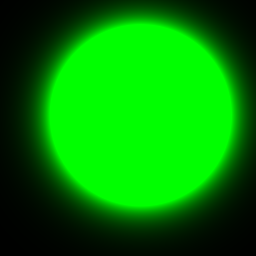

In [74]:
from nerfpg import tensor_to_image, image_to_tensor

tensor_to_image(radiance.color.reshape(*res, 3).permute(2, 0, 1))

In [75]:
class CachedFrame:
    def __init__(self, frame: Frame, dev: tch.device):
        self.image = image_to_tensor(frame.image, dev)
        self.matrix = frame.matrix  # TODO: Cache matrix

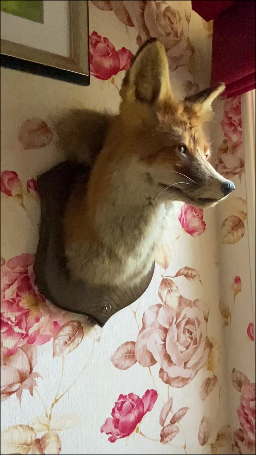

In [76]:
def sample_image(img: tch.Tensor, coords: tch.Tensor) -> tch.Tensor:
    return (
        F.grid_sample(
            img.unsqueeze(0),
            (coords * 2.0 - 1.0).unsqueeze(0).unsqueeze(0),
            align_corners=False,
        )
        .squeeze(0)
        .squeeze(1)
    )


frames = [CachedFrame(frame, dev) for frame in scene.frames]

shape = (256, int(256 * (scene.shape[1] / scene.shape[0])))
tensor_to_image(
    sample_image(
        frames[0].image,
        grid(shape, dev).transpose(0, 1).flatten(0, 1),
    ).reshape((-1, shape[1], shape[0]))
)

In [77]:
def sample_model(
    model: nn.Module,
    coords: tch.Tensor,
    scene: Scene,
    transform: list[list[float]],
    step_size: float,
    max_distance: float,
) -> tch.Tensor:
    rays = rays_init(coords, transform, scene.angles, offset=scene.offset)
    return raymarch(
        lambda xs: model.forward(xs),
        rays,
        (0.0, 2.0 * step_size),
        int(max_distance / step_size),
    ).color


def infer(
    model: nn.Module,
    res: tuple[int, int],
    dev: tch.device,
    scene: Scene,
    transform: list[list[float]],
    step_size: float,
    max_distance: float,
) -> Image:
    model.train(False)
    rays = rays_grid(res, dev, transform, scene.angles, offset=scene.offset)
    ys = raymarch(
        lambda xs: model.forward(xs), rays, step_size, int(max_distance / step_size)
    )
    out = ys.color.transpose(0, 1).reshape((-1, res[1], res[0]))
    return tensor_to_image(out)

In [86]:
step_size = 0.05
max_distance = 4.0

In [87]:
from nerfpg import encode_coord


class Model(nn.Module):
    def __init__(self, dim: int, n_modes: int, scale: float):
        super().__init__()
        self.first = nn.Sequential(
            nn.Linear(3 * n_modes, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, 1 + dim),
        )
        self.second = nn.Linear(3 + dim, 3)
        self.n_modes = n_modes
        self.scale = scale

    def forward(self, rays: Rays) -> Radiance:
        pos_enc = encode_coord(rays.pos, self.n_modes, self.scale)
        middle = self.first.forward(pos_enc)
        density, features = middle[:, :1], middle[:, 1:]
        color = self.second.forward(tch.cat([rays.dir, features], dim=-1))
        return Radiance(F.elu(color), density)


model = Model(dim=64, n_modes=64, scale=1.0 / max_distance)
model = model.to(dev)
epoch = 0

In [88]:
batch_size = 16 * 1024
optim = tch.optim.AdamW(model.parameters(), lr=3e-3)

'9: 0.011264319531619549'

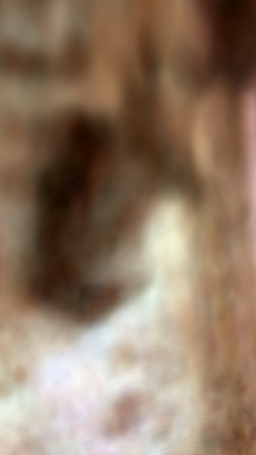

In [89]:
from IPython.display import display

display_loss = display(display_id=True)
display_sample = display(display_id=True)

for _ in range(10):
    model.train(True)

    total_loss = 0.0
    for frame in frames[:2] * (len(frames) // 2):
        model.zero_grad()

        xs = tch.rand((batch_size, 2), device=dev)
        ys = sample_model(
            model,
            xs,
            scene,
            frame.matrix,
            step_size,
            max_distance,
        ).transpose(0, 1)

        ref = sample_image(frame.image, xs)
        loss = F.mse_loss(ys, ref)
        total_loss += loss.numpy(force=True)

        loss.backward()
        optim.step()

    total_loss /= len(frames)
    display_loss.update(f"{epoch}: {total_loss}")
    epoch += 1

    display_sample.update(
        infer(model, shape, dev, scene, frames[0].matrix, step_size, max_distance)
    )

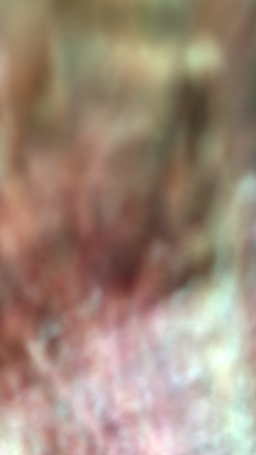

In [85]:
infer(
    model,
    shape,
    dev,
    scene,
    scene.frames[3].matrix,
    step_size,
    max_distance,
)